In [1]:
!pip install albumentations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch.utils.data import RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomGamma
)

from metrics import dice
from data import NeuronSegmDataset

from torch import nn
import torch

from encoders import ResNetEncoders
from unet import UNet

def tonp(t):
    return t.detach().cpu().numpy()
    
def process_batch(b):
    X, y  = b
    X = X.to(DEVICE)
    y = torch.tensor(y, dtype=torch.float).to(DEVICE)
    return X, y

def prediction_to_numpy(pred):
    return pred.sigmoid().detach().cpu().numpy() 

def evaluate(model, loader, threshold):
    model = model.eval()
    for b in loader:
        X, y = process_batch(b)
        res = model(X)
    val_loss = nn.BCEWithLogitsLoss()(res, y)
    pred_Y, real_Y = prediction_to_numpy(res) > threshold, tonp(y)> threshold
    dices = []
    for ypred, yreal in zip(pred_Y, real_Y):
        dices.append(dice(ypred, yreal))
    return np.array(dices).mean(), val_loss.detach().cpu().numpy()

### Create a Fully Connected Segmentation Architecture 
This means it will work similary to any other CONV architecture, in the end it will map the dense layer into a 1,192,192 shape

In [56]:
def create_conv(in_ft, out_ft):
    conv = nn.Sequential(
            nn.Conv2d(in_ft, out_ft, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(out_ft),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
    return conv


class SSN(nn.Module):
    def __init__(self):
        super(SSN, self).__init__()
        # Create 4 conv layers with 16, 32, 64, 16 output features
        # Create a Linear layer that will map this into a 192x192 vector
        # Assume input shape to be (1, 1, 192, 192)
        self.conv1 = create_conv(1, 16)
        self.conv2 = create_conv(16, 32)
        self.conv3 = create_conv(32, 64)
        self.conv4 = create_conv(64, 16)
        self.linear = nn.Linear(2304, 192 * 192)
        
    def forward(self, x):
        after_conv = self.conv1(x)
        after_conv = self.conv2(after_conv)
        after_conv = self.conv3(after_conv)
        after_conv = self.conv4(after_conv)
        flatten = after_conv.reshape(after_conv.size(0), -1)
        
        #import pdb
        #pdb.set_trace()
        
        lin = self.linear(flatten)
        # forward image trought the network, remember to reshape accordingly we want to see (BS, 1, 192, 192)
        return lin.view(x.shape[0], 1, 192, 192)

### Create a Unet-Like architecture this means a network that will have the pooling path, upsampling and lateral connections.

In [61]:
def create_ups(in_features, out_features):
    ups = nn.Sequential(
        #nn.Upsample(mode = 'bilinear', scale_factor = 2),
        nn.ConvTranspose2d(in_features, out_features, kernel_size = 2, stride = 2),
        #nn.Conv2d(in_features, out_features, kernel_size = 1, stride = 1),
        nn.BatchNorm2d(out_features),
        nn.ReLU())
    return ups    

class AlaUnet(nn.Module):
    def __init__(self):
        super(AlaUnet, self).__init__()
        self.conv1 = create_conv(1, 16)
        self.conv2 = create_conv(16, 32)
        self.conv3 = create_conv(32, 64)
        self.conv4 = create_conv(64, 16)
        self.ups5  = create_ups(16, 64)
        self.ups6  = create_ups(128, 32)#create_ups(64, 32)
        self.ups7  = create_ups(64, 16)#create_ups(32, 16)
        self.ups8  = create_ups(32, 1)#create_ups(16, 1)
              
    def forward(self, x):
        #print(f"Shape X: {x.shape}")
        c1_out = self.conv1(x)
        #print(f"Shape C1: {c1_out.shape}")
        c2_out = self.conv2(c1_out)
        #print(f"Shape C2: {c2_out.shape}")
        c3_out = self.conv3(c2_out)
        #print(f"Shape C3: {c3_out.shape}")        
        c4_out = self.conv4(c3_out)
        #print(f"Shape C4: {c4_out.shape}")
        u5_out = self.ups5(c4_out)
        u5_out = torch.cat((u5_out, c3_out), dim = 1)
        #print(f"Shape U5: {u5_out.shape}")
        u6_out = self.ups6(u5_out)
        u6_out = torch.cat((u6_out, c2_out), dim = 1)        
        #print(f"Shape U6: {u6_out.shape}")
        u7_out = self.ups7(u6_out)
        u7_out = torch.cat((u7_out, c1_out), dim = 1)    
        #print(f"Shape U7: {u7_out.shape}")
        u8_out = self.ups8(u7_out)
        
        #print(f"Shape U8: {u8_out.shape}")
        return u8_out

In [97]:
neuron_target = './train-labels.tif'
neuron_train = './train-volume.tif'


trans_train = transforms.Compose([transforms.Resize(192), 
                                  transforms.ToTensor()])
trans_test = transforms.Compose([transforms.Resize(192), 
                                 transforms.ToTensor()])

aug = Compose([
#     RandomGamma(), 
               VerticalFlip(), 
#                HorizontalFlip(),
#                RandomRotate90(), 
#                GridDistortion(),
#                ElasticTransform(),
#                OpticalDistortion(distort_limit=1, shift_limit=1)
])


train_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train, augmenter=aug)
test_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_test)
train_ds_val = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train)


random_training_sampler = RandomSampler(train_ds)
train_idx , test_idx = train_test_split(range(len(train_ds)), test_size=0.15)

random_sampler_train = RandomSampler(train_idx)
sampler_test = SequentialSampler(test_idx)

training_data_loader = DataLoader(train_ds, batch_size=1, num_workers=1, sampler=random_training_sampler)
test_data_loader = DataLoader(test_ds, batch_size=6, num_workers=1, sampler=sampler_test)
train_ds_val_loader = DataLoader(train_ds_val, batch_size=6, num_workers=1, sampler=random_training_sampler)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model = AlaUnet().to(DEVICE)
model = SSN().to(DEVICE)

#optim = torch.optim.Adam(model.parameters())
optim = torch.optim.Adam(model.parameters(), lr = 0.0001)
epochs = 1000
loss_bce = nn.BCEWithLogitsLoss()
loss = 0
THRESHOLD = 0.5
history = defaultdict(list)

/opt/conda/envs/dsr/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0
dice 0.8443118098340257
loss 0.62903255
train_dice 0.8622850532849928
train_loss 0.62230843
>>> Average time per epoch = 1.009s.
epoch 10
dice 0.8725403338780057
loss 0.44584435
train_dice 0.8985573369762454
train_loss 0.39224094
>>> Average time per epoch = 1.003s.
epoch 20
dice 0.8931010422453671
loss 0.37821114
train_dice 0.8983381354090283
train_loss 0.36268744
>>> Average time per epoch = 1.003s.
epoch 30
dice 0.9299722051723567
loss 0.30416578
train_dice 0.9461058194057467
train_loss 0.27744737
>>> Average time per epoch = 1.002s.
epoch 40
dice 0.9723009354846255
loss 0.23404507
train_dice 0.9698348957691781
train_loss 0.22773358
>>> Average time per epoch = 1.002s.
epoch 50
dice 0.9790066105773398
loss 0.20214143
train_dice 0.977073732043399
train_loss 0.19856358
>>> Average time per epoch = 1.000s.
epoch 60
dice 0.9848796262567475
loss 0.18255287
train_dice 0.9913716668075798
train_loss 0.16390398
>>> Average time per epoch = 1.000s.
epoch 70
dice 0.9882786773404237
los

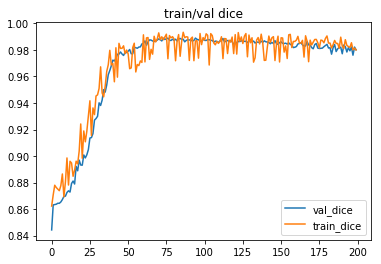

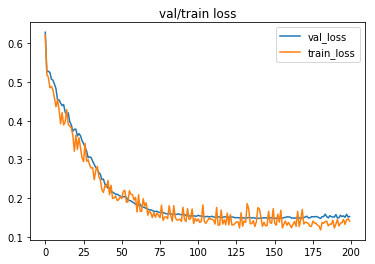

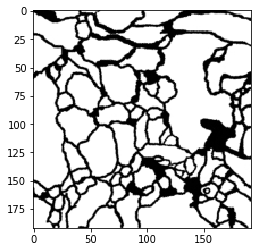

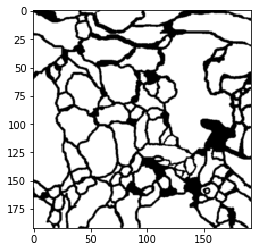

In [98]:
import time

epochs=200

tic = time.time()
for i, _ in enumerate(range(epochs)):
    for batch in training_data_loader:
        X, y = process_batch(batch)
        prediction = model(X)  # [N, 2, H, W]
        loss = loss_bce(prediction, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()   
        
    val_mean_dice, val_loss = evaluate(model, test_data_loader, threshold=THRESHOLD)
    train_mean_dice, train_loss = evaluate(model, train_ds_val_loader, threshold=THRESHOLD)

    model.train()
    
    history['val_dice'].append(val_mean_dice)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_mean_dice)
    history['train_loss'].append(train_loss)
    
    if (i % 10) == 0:
        print("epoch", i)
        print('dice', val_mean_dice)
        print('loss', val_loss)
        print('train_dice', train_mean_dice)
        print('train_loss', train_loss)    
        toc = time.time()
        print(f">>> Average time per epoch = {(toc - tic) / (i + 1):.3f}s.")

df = pd.DataFrame(history)

plt.figure()
plt.title('train/val dice')
plt.plot(df.val_dice)
plt.plot(df.train_dice)
plt.legend(['val_dice', 'train_dice'])
plt.figure()
plt.title('val/train loss')
plt.plot(df.val_loss)
plt.plot(df.train_loss)
plt.legend(['val_loss', 'train_loss'])


plt.figure()
plt.imshow(prediction[0][0].detach().sigmoid().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(y.detach()[0][0].cpu().numpy(), cmap='gray')


In [92]:
neuron_target = './train-labels.tif'
neuron_train = './train-volume.tif'


trans_train = transforms.Compose([transforms.Resize(192), 
                                  transforms.ToTensor()])
trans_test = transforms.Compose([transforms.Resize(192), 
                                 transforms.ToTensor()])

aug = Compose([
#     RandomGamma(), 
               VerticalFlip(), 
#                HorizontalFlip(),
#                RandomRotate90(), 
#                GridDistortion(),
#                ElasticTransform(),
#                OpticalDistortion(distort_limit=1, shift_limit=1)
])


train_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train, augmenter=aug)
test_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_test)
train_ds_val = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train)


random_training_sampler = RandomSampler(train_ds)
train_idx , test_idx = train_test_split(range(len(train_ds)), test_size=0.15)

random_sampler_train = RandomSampler(train_idx)
sampler_test = SequentialSampler(test_idx)

training_data_loader = DataLoader(train_ds, batch_size=1, num_workers=1, sampler=random_training_sampler)
test_data_loader = DataLoader(test_ds, batch_size=6, num_workers=1, sampler=sampler_test)
train_ds_val_loader = DataLoader(train_ds_val, batch_size=6, num_workers=1, sampler=random_training_sampler)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AlaUnet().to(DEVICE)
#model = SSN().to(DEVICE)

#optim = torch.optim.Adam(model.parameters())
optim = torch.optim.Adam(model.parameters(), lr=0.05)
#epochs = 1000
loss_bce = nn.BCEWithLogitsLoss()
loss = 0
THRESHOLD = 0.5
history = defaultdict(list)

/opt/conda/envs/dsr/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0
dice 0.7639808305452904
loss 0.52464354
train_dice 0.7731861354412911
train_loss 0.50926954
>>> Average time per epoch = 0.613s.
epoch 10
dice 0.9249082213152271
loss 0.33052844
train_dice 0.9302656100871621
train_loss 0.30051684
>>> Average time per epoch = 0.615s.
epoch 20
dice 0.9263008169965528
loss 0.31940553
train_dice 0.9179175892811765
train_loss 0.31127733
>>> Average time per epoch = 0.613s.
epoch 30
dice 0.9284302010301388
loss 0.31112427
train_dice 0.9325448715444957
train_loss 0.30898482
>>> Average time per epoch = 0.609s.
epoch 40
dice 0.9229264492973304
loss 0.30781785
train_dice 0.9301154449039787
train_loss 0.28404212
>>> Average time per epoch = 0.610s.
epoch 50
dice 0.9219673568862714
loss 0.31635708
train_dice 0.9280870704815488
train_loss 0.29048342
>>> Average time per epoch = 0.611s.
epoch 60
dice 0.9310201959013227
loss 0.29863644
train_dice 0.9210600403807526
train_loss 0.30978316
>>> Average time per epoch = 0.610s.
epoch 70
dice 0.9334280875162484
lo

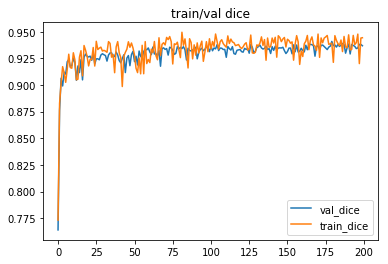

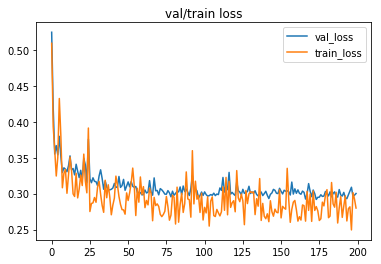

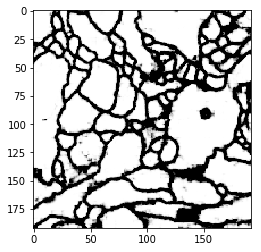

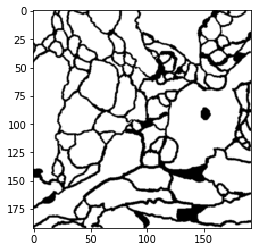

In [93]:
import time

epochs=200

tic = time.time()
for i, _ in enumerate(range(epochs)):
    for batch in training_data_loader:
        X, y = process_batch(batch)
        prediction = model(X)  # [N, 2, H, W]
        loss = loss_bce(prediction, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()   
        
    val_mean_dice, val_loss = evaluate(model, test_data_loader, threshold=THRESHOLD)
    train_mean_dice, train_loss = evaluate(model, train_ds_val_loader, threshold=THRESHOLD)

    model.train()
    
    history['val_dice'].append(val_mean_dice)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_mean_dice)
    history['train_loss'].append(train_loss)
    
    if (i % 10) == 0:
        print("epoch", i)
        print('dice', val_mean_dice)
        print('loss', val_loss)
        print('train_dice', train_mean_dice)
        print('train_loss', train_loss)    
        toc = time.time()
        print(f">>> Average time per epoch = {(toc - tic) / (i + 1):.3f}s.")

df = pd.DataFrame(history)

plt.figure()
plt.title('train/val dice')
plt.plot(df.val_dice)
plt.plot(df.train_dice)
plt.legend(['val_dice', 'train_dice'])
plt.figure()
plt.title('val/train loss')
plt.plot(df.val_loss)
plt.plot(df.train_loss)
plt.legend(['val_loss', 'train_loss'])


plt.figure()
plt.imshow(prediction[0][0].detach().sigmoid().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(y.detach()[0][0].cpu().numpy(), cmap='gray')

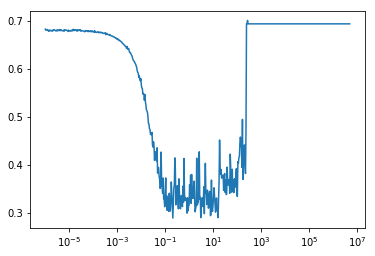

In [91]:
# LR finder
lrepochs = 20
OPTIMIZER = 'Adam'
INITIAL_LR = 10e-7
losses = []
lrs = []
cnn = AlaUnet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=0.001)

for param_group in optimizer.param_groups:
    param_group['lr'] = INITIAL_LR

for e in range(lrepochs):
    for i, batch in enumerate(training_data_loader):
        #if i % 100 == 0: 
        #    print(i)
        #    print(loss)

        optimizer.zero_grad()
        X, y = batch
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = cnn(X)

        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        if loss > 10:
            break

        current_lr = lr = optimizer.param_groups[0]['lr']
        losses.append(loss)
        lrs.append(current_lr)

        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr * 1.05

        if i == 1000:
            break
    
df = pd.DataFrame([l.detach().cpu().numpy() for l in losses])
df['lrs'] = lrs
ax = plt.plot(df['lrs'], df[0])
plt.xscale('log')

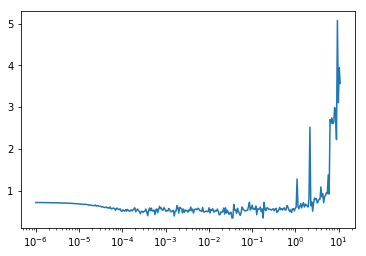

In [94]:
# LR finder
lrepochs = 20
OPTIMIZER = 'Adam'
INITIAL_LR = 10e-7
losses = []
lrs = []
cnn = SSN().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=0.001)

for param_group in optimizer.param_groups:
    param_group['lr'] = INITIAL_LR

for e in range(lrepochs):
    for i, batch in enumerate(training_data_loader):
        #if i % 100 == 0: 
        #    print(i)
        #    print(loss)

        optimizer.zero_grad()
        X, y = batch
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = cnn(X)

        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        if loss > 10:
            break

        current_lr = lr = optimizer.param_groups[0]['lr']
        losses.append(loss)
        lrs.append(current_lr)

        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr * 1.05

        if i == 1000:
            break
    
df = pd.DataFrame([l.detach().cpu().numpy() for l in losses])
df['lrs'] = lrs
ax = plt.plot(df['lrs'], df[0])
plt.xscale('log')